In [1]:
## plot boilerplate
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

## Scikit Learn *Working with Text* Example

In the [Scikit Learn](http://scikit-learn.org/stable/) documentation there is an [article](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) providing details about using Scikit learn to perform classification on the newsgroup data set.  One example in the article that produces good results is as follows:

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test',
                                 categories=categories, shuffle=True, random_state=42)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=42)),
])
_ = text_clf.fit(twenty_train.data, twenty_train.target)
predicted = text_clf.predict(twenty_test.data)

print(metrics.classification_report(twenty_test.target, predicted,
      target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.81      0.87       319
         comp.graphics       0.88      0.97      0.92       389
               sci.med       0.94      0.90      0.92       396
soc.religion.christian       0.90      0.95      0.93       398

           avg / total       0.92      0.91      0.91      1502



## Purpose of this Notebook

The rest of this notebook adapts the above example for the purposes of learning more about:

- sklearn pipelines
- custom sklearn TransformerMixins and BaseEstimators
- feeding sklearn pipelines from jsonl files

The classification problem being tested is slightly different than the one presented above. Namely:

- the data is in jsonl format.. that is line delimited json dictionaries with keys for content and label
- the classification problem is binary

---

## Preparing Test Data

To simulate jsonl file conditions:

- First we create a training data set by writing the newsgroup training data to a jsonl file, `test_data/train.jsonl`.  We will use `comp.graphics` as our target class so we will apply the label 1 if the newsgroup article is `comp.graphics` and 0 otherwise. 

- Next we write all categories from the newsgroup test data set line to a jsonl file, `test_data/test.jsonl` with the labels transformed to 0,1 as above.


In [3]:
## prepare the data for testing
import json

def ng_dir(data_type):
    ''' simplify newsgroup jsonl acess, data_type = 'test' or 'train'
    '''
    return 'test_data/%s.jsonl' % data_type


def write_ng_to_jsonl(ngdir, ngdat):
    ''' write newsgroup data to jsonl file
    '''
    with open(ngdir, 'w') as f:
        for i in range(len(ngdat.data)):
            json.dump(
                {'label': int(ngdat.target[i] == 3),
                 'name': ngdat.target_names[ngdat.target[i]],
                 'content': ngdat.data[i]
            }, f)
            f.write('\n')


write_ng_to_jsonl(ng_dir('train'), twenty_train)
write_ng_to_jsonl(ng_dir('test'), twenty_test)

Now that we have `train_data.jsonl` and `test_data.jsonl` we can use a modified version of the above example to perform binary classification based off of the jsonl data:

In [6]:
import itertools as itt
from textprocess import StripTransform

text_clf = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

with open(ng_dir('train'), 'r') as train, open(ng_dir('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    predicted = text_clf.fit([i['content'] for i in x],
                             [j['label'] for j in y]).predict([i['content'] for i in u])
    print(metrics.classification_report([j['label'] for j in v], predicted,
                                        target_names=['not comp.graphics', 'comp.graphics']))

                   precision    recall  f1-score   support

not comp.graphics       0.93      0.98      0.96      1104
    comp.graphics       0.94      0.81      0.87       398

      avg / total       0.94      0.94      0.93      1502



This also performs fairly well. Note that it performs better than the previous example because we reduced the number of classes.  Switching from `hinge` loss to `perceptron` loss yields slightly better results:

In [7]:
text_clf = Pipeline([
                     ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

with open(ng_dir('train'), 'r') as train, open(ng_dir('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    predicted = text_clf.fit([i['content'] for i in x],
                             [j['label'] for j in y]).predict([i['content'] for i in u])
    print(metrics.classification_report([j['label'] for j in v], predicted,
                                        target_names=['not comp.graphics', 'comp.graphics']))

                   precision    recall  f1-score   support

not comp.graphics       0.95      0.97      0.96      1104
    comp.graphics       0.91      0.84      0.88       398

      avg / total       0.94      0.94      0.94      1502



The method `tee` from python `itertools` is used to stream the documents into the pipeline. However, the pipeline processes in memory so all documents are loaded from disk during `predict`.  This could be an issue when dealing with a larger set of documents. 

## Cosine Distance as BaseEstimator

---

Below we look at using Cosine Distance as a means to classify the newsgroup data. The approach stores the tfidf vector of the target class in the `train` data set during the `fit` stage.  When `predict` is called the Cosine distance is calculated between the `test` data and the stored target class.  We would expect documents in the `test` set from the target class would have a lower Cosine distance than those that are not in the target class.

In [8]:
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import linear_kernel

class CosineSim(BaseEstimator):
    ''' store vector of target, predict by calculating cosine distance
    '''
    def transform(self, X, **transform_params):
        return self

    def fit(self, X, y, **fit_params):
        ''' X is a tfidf matrix of the training set
            reduce X to the tfidf of only documents in target class
        '''
        indices = np.array([i for i in range(len(y)) if y[i] == 1])
        self.target_tfidf = X[indices, :].mean(axis=0)
        
    def predict(self, X, y=None, **predict_params):
        d = 1 - linear_kernel(X, self.target_tfidf).flatten()
        return d

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('cosine', CosineSim()) 
])

with open(ng_dir('train'), 'r') as train, open(ng_dir('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    d = pipe.fit([i['content'] for i in x],
                 [j['label'] for j in y]).predict([i['content'] for i in u])

## Examining the Results

Above we defined `d` which is a vector of similarity scores for each document.  It is in the same order as the original candidate json list. We can use this order to combine the scores with the labels and generate plots or tables.

---

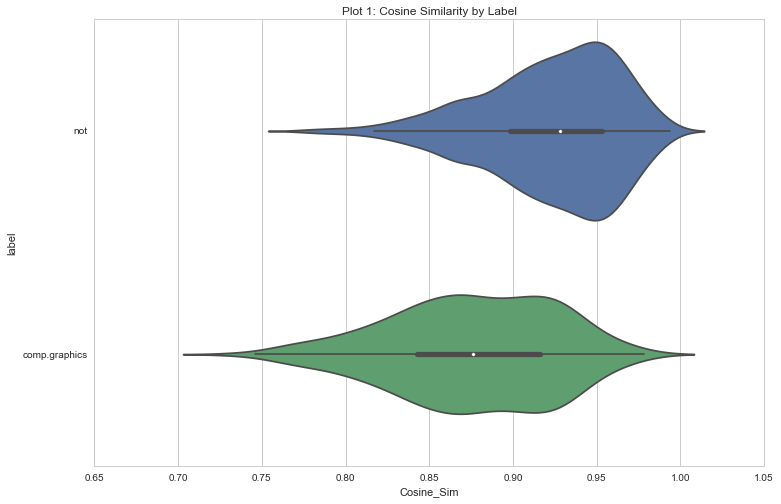

In [10]:
with open(ng_dir('test'), 'r') as test:
    _, v = itt.tee((json.loads(line) for line in test))
    result = [r for r in zip(['comp.graphics' if i['label'] == 1
                              else 'not'
                              for i in v], d)]
    
pd.DataFrame(result, columns=['label', 'score']).to_csv('temp.csv')
ax = plt.axes()
sns.violinplot(x="Cosine_Sim", y="label",
              data=pd.DataFrame(result, columns=['label', 'Cosine_Sim']),
              jitter=True)
ax.set_title('Plot 1: Cosine Similarity by Label')
plt.show()

From the above plot we can see that the newsgroup data is not highly seperable based on Cosine distance.  In order to classify the documents we would need assign a decision rule but `Plot 1` indicates that this would not be very effective.  However, Comparing the groups we can see that we do achieve some lift.

## Cosine Similarity as a Feature

Since it looks like Cosine similarity yields lift, let's try using it as a feature for the `SGDClassifier`.

In [11]:
from sklearn.base import TransformerMixin

class CosineSimTrans(TransformerMixin):
    ''' store vector of target, predict by calculating cosine distance
    '''
    def transform(self, X, **transform_params):
        d = 1 - linear_kernel(self.target_tfidf, X).flatten()
        return d.reshape(-1, 1)

    def fit(self, X, y, **fit_params):
        indices = np.array([i for i in range(len(y)) if y[i] == 1])
        self.target_tfidf = X[indices, :].mean(axis=0)
        return self

In [12]:
from sklearn.pipeline import FeatureUnion

pipe = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[
                ('trans1', Pipeline([
                    ('tfidf', TfidfVectorizer())
                ])),
                ('trans2', Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('cosim', CosineSimTrans()),
                ]))
            ]
        )),
        ('estimators', Pipeline([
                    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                                          alpha=1e-3, n_iter=5, random_state=42))
                    ])
        )
])

In [13]:
with open(ng_dir('train'), 'r') as train, open(ng_dir('test'), 'r') as test:
    x, y = itt.tee((json.loads(line) for line in train))
    u, v = itt.tee((json.loads(line) for line in test))
    predicted = pipe.fit([i['content'] for i in x],
                 [j['label'] for j in y]).predict([i['content'] for i in u])
    print(metrics.classification_report([j['label'] for j in v], predicted,
                                    target_names=['not comp.graphics', 'comp.graphics']))

                   precision    recall  f1-score   support

not comp.graphics       0.98      0.95      0.97      1104
    comp.graphics       0.88      0.96      0.92       398

      avg / total       0.96      0.95      0.95      1502



And we have improved our classification's performance on the test data set.